# NOTEBOOK RUN ON GOOGLECOLAB

In [1]:
import tensorflow as tf
from PIL import Image
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import imutils
import pickle
import tqdm

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, Activation, ReLU, Input, Dropout, MaxPooling2D, concatenate, Conv2DTranspose
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from tensorflow.keras.optimizers import Adam
import os

In [1]:
## SET ON GPU ##
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

# DATASET

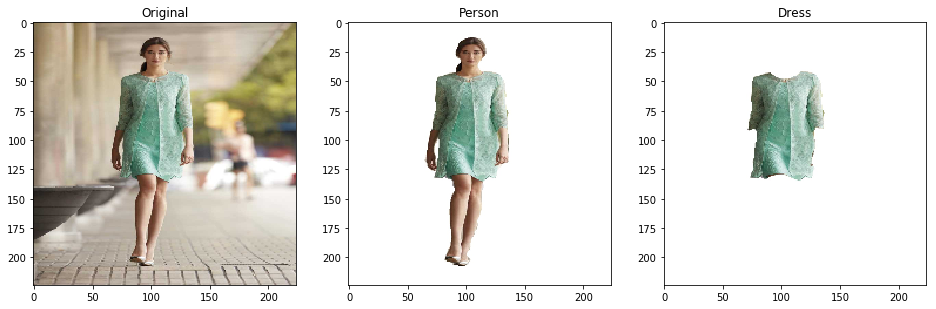

In [2]:
### PLOT ONE SAMPLE OF IMAGE IN THE DATA ###
original = cv.imread('./original77.jpg')
original = cv.resize(original,(224,224))
dress = cv.imread('./dress77.jpg')
dress = cv.resize(dress,(224,224))
body = cv.imread('./body77.jpg')
body = cv.resize(body,(224,224))

plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.title('Original')
plt.imshow(cv.cvtColor(original, cv.COLOR_BGRA2RGB))
plt.subplot(1,3,2)
plt.title('Person')
plt.imshow(cv.cvtColor(body, cv.COLOR_BGRA2RGB))
plt.subplot(1,3,3)
plt.title('Dress')
plt.imshow(cv.cvtColor(dress, cv.COLOR_BGRA2RGB))

# PREPARE IMAGES FOR SEGMENTATION

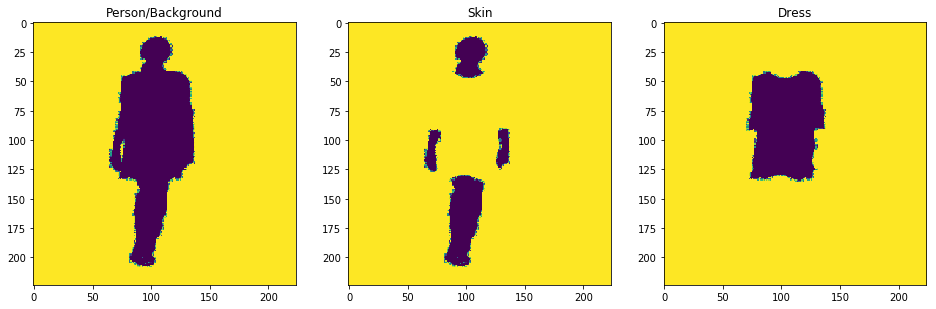

In [3]:
dress = cv.imread('./dress77.jpg',0)
body = cv.imread('./body77.jpg',0)

### ENCODE DRESS ###
dress[dress == 255] = 0
dress[dress > 0] = 255
dress = cv.resize(dress,(224,224))

### ENCODE BODY ###
body[body == 255] = 0
body[body > 0] = 255
body = cv.resize(body,(224,224))

### ENCODE SKIN ###
skin = body - dress


plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.title('Person/Background')
bg = (255 - body)/255
plt.imshow(bg)
plt.subplot(1,3,2)
plt.title('Skin')
skin = (255 - skin)/255
plt.imshow(skin)
plt.subplot(1,3,3)
plt.title('Dress')
dress = (255 - dress)/255
plt.imshow(dress)

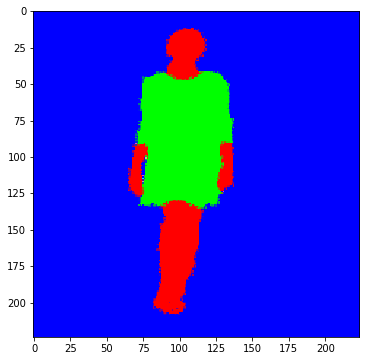

In [4]:
### COMBINE BACKGROUND, SKIN, DRESS ###
gt = np.zeros((224,224,3))
gt[:,:,0] = (1-skin)
gt[:,:,1] = (1-dress)
gt[:,:,2] = bg

plt.figure(figsize=(6,6))
plt.imshow(gt)

In [0]:
### ENCODE BACKGROUND, SKIN, DRESS FOR ALL TRAIN IMAGES ###

images_original = []
images_gt = []

mean = np.zeros((224,224,3))
n_img = 81

for i in tqdm.tqdm(range(1,n_img+1)):
    
    original = cv.imread('./data/original/original'+str(i)+'.jpg')
    original = cv.resize(original,(224,224))
    images_original.append(original)
    mean[:,:,0]=mean[:,:,0]+original[:,:,0]
    mean[:,:,1]=mean[:,:,1]+original[:,:,1]
    mean[:,:,2]=mean[:,:,2]+original[:,:,2]
    
    body = cv.imread('./data/body/body'+str(i)+'.jpg',0)
    dress = cv.imread('./data/dress/dress'+str(i)+'.jpg',0)
    
    dress[dress == 255] = 0
    dress[dress > 0] = 255
    dress = cv.resize(dress,(224,224))

    body[body == 255] = 0
    body[body > 0] = 255
    body = cv.resize(body,(224,224))

    skin = body - dress
    bg = (255 - body)/255
    skin = (255 - skin)/255
    dress = (255 - dress)/255
    
    gt = np.zeros((224,224,3))
    gt[:,:,0] = (1-skin)
    gt[:,:,1] = (1-dress)
    gt[:,:,2] = bg
   
    images_gt.append(gt)

mean = mean / n_img
mean = mean.astype('int')

100%|██████████| 81/81 [01:08<00:00,  1.14it/s]


In [0]:
#pickle.dump(mean, open("./mean81.pkl", "wb"))

# TRAIN UNET

In [0]:
def custom_activation(x):
    return K.relu(x, alpha=0.0, max_value=1)


def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

smooth = 1.

In [0]:
def get_unet(do=0, activation=ReLU):
  
    inputs = Input((None, None, 3))
    conv1 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(inputs)))
    conv1 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(conv1)))
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(pool1)))
    conv2 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(conv2)))
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(pool2)))
    conv3 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(conv3)))
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(pool3)))
    conv4 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(conv4)))
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Dropout(do)(activation()(Conv2D(512, (3, 3), padding='same')(pool4)))
    conv5 = Dropout(do)(activation()(Conv2D(512, (3, 3), padding='same')(conv5)))

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(up6)))
    conv6 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(conv6)))

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(up7)))
    conv7 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(conv7)))

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(up8)))
    conv8 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(conv8)))

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(up9)))
    conv9 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(conv9)))

    conv10 = Conv2D(3, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-3), loss=losses.binary_crossentropy, metrics=['accuracy'])

    return model

In [0]:
x_raw = np.asarray(images_original) - mean.reshape(-1,224,224,3) 
x_gt = np.asarray(images_gt).reshape(-1,224,224,3) 

In [0]:
model = get_unet()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_114 (Conv2D)             (None, None, None, 3 896         input_7[0][0]                    
__________________________________________________________________________________________________
re_lu_108 (ReLU)                (None, None, None, 3 0           conv2d_114[0][0]                 
__________________________________________________________________________________________________
dropout_108 (Dropout)           (None, None, None, 3 0           re_lu_108[0][0]                  
__________________________________________________________________________________________________
conv2d_115

In [0]:
history = model.fit(x_raw, x_gt, epochs=120)

Epoch 1/120
81/81 [==============================] - 4s 52ms/sample - loss: 52.0267 - acc: 0.5463
Epoch 2/120
81/81 [==============================] - 3s 32ms/sample - loss: 33.1465 - acc: 0.7927
Epoch 3/120
81/81 [==============================] - 3s 32ms/sample - loss: 21.0042 - acc: 0.7896
Epoch 4/120
81/81 [==============================] - 3s 31ms/sample - loss: 17.7321 - acc: 0.7446
Epoch 5/120
81/81 [==============================] - 3s 31ms/sample - loss: 15.3721 - acc: 0.7675
Epoch 6/120
81/81 [==============================] - 3s 31ms/sample - loss: 14.4174 - acc: 0.8018
Epoch 7/120
81/81 [==============================] - 3s 31ms/sample - loss: 13.9712 - acc: 0.8106
Epoch 8/120
81/81 [==============================] - 3s 32ms/sample - loss: 13.8914 - acc: 0.8119
Epoch 9/120
81/81 [==============================] - 3s 32ms/sample - loss: 13.3527 - acc: 0.8203
Epoch 10/120
81/81 [==============================] - 3s 32ms/sample - loss: 13.1950 - acc: 0.8235
Epoch 11/120
81/81 

In [0]:
#model.save('./fashion_unet.h5')